In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as dist

import time

In [38]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = "cpu"
print(device)

cpu


In [39]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(root='./data',download=False, train=True, transform=transform)
testset = datasets.MNIST(root='./data', download=False, transform=transform)

# Prepare the training set
train_features = torch.cat([data[0].view((1,28*28)) for data in trainset])
train_labels = torch.Tensor([data[1] for data in trainset]).type(torch.long)



In [43]:

class LinearVariational(nn.Module):    
    def __init__(self, in_features, out_features, num_samples, prior_scale, mean_forward=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_samples = num_samples
        self.mean_forward = mean_forward
        
        self.prior = dist.Normal(loc = torch.zeros(out_features, in_features),
                                 scale=prior_scale*torch.ones(out_features, in_features))
        
        self.mu_W = nn.Parameter(torch.zeros(out_features, in_features))
        self.s_W = nn.Parameter(torch.zeros(out_features, in_features))

    def get_weight_samples(self, num_samples):
        # reparameterize
        epsilon_dist = dist.Normal(loc = torch.zeros(self.mu_W.size()[0], self.mu_W.size()[1]),
                                                    scale = torch.ones(self.mu_W.size()[0], self.mu_W.size()[1]))
        epsilon = epsilon_dist.sample((num_samples,))
        weights = self.mu_W + F.softplus(self.s_W)*epsilon
        return weights
    
    def linear(self, weight_samples, x):
        return torch.matmul(weight_samples.unsqueeze(0), x.unsqueeze(1).unsqueeze(3)).squeeze()
    
    def forward(self, x):
        weight_samples = self.get_weight_samples(self.num_samples)
        out = self.linear(weight_samples, x)
        if (self.mean_forward):
            return out.mean(1)
        else:
            return out
        
    

In [44]:
class Variational_Network(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, num_samples):
        super().__init__()
        
        self.latents = LinearVariational(in_features=50,
                              out_features=10, 
                              num_samples=num_samples,
                              prior_scale=5.,
                              mean_forward=False)
        
        self.layers = nn.Sequential(
            # nn.Linear(28*28, 50),
            LinearVariational(in_features=28*28,
                              out_features=50,
                              num_samples=num_samples,
                              prior_scale=5.),
            nn.LeakyReLU(0.1),
            self.latents
        )
    
    def forward(self, x):
        return self.layers(x)
    
    # def evaluate_log_prior(prior, weight_samples):
    #     return torch.mean(prior.log_prob(weight_samples))

    # def evaluate_log_q(mean, scale, weight_samples):
    #     q_dist = dist.Normal(mean, F.softplus(scale))
    #     return torch.mean(q_dist.log_prob(weight_samples))

    
    
    def evaluate_log_likelihood(self, features, labels):
        # preds = self.linear(weight_samples, features) # performs forward, which I want to do explicitly
        preds = self.forward(features)
        data_batch, param_batch, num_classes = preds.shape
        repeated_labels = torch.cat([y.repeat((param_batch,)) for y in labels])
        loss = torch.nn.CrossEntropyLoss(reduction='none')
        log_lk_loss = loss(preds.reshape((data_batch*param_batch, num_classes)), repeated_labels)
        log_lk_loss = -log_lk_loss.reshape((data_batch, param_batch))
        return torch.mean(torch.sum(log_lk_loss, 0))


    def evaluate_ELBO(self, features, labels, correction = 1):
        # weight_samples = self.get_weight_samples(num_samples)
        avg_log_lk = self.evaluate_log_likelihood(features, labels) # y
        q = torch.distributions.normal.Normal(self.latents.mu_W, F.softplus(self.latents.s_W))
        return correction * (avg_log_lk + torch.mean(torch.distributions.kl.kl_divergence(self.latents.prior, q)))
    
    
    def compute_marginalized_predictions(self, features, num_samples):
        pre_preds = self.forward(features)
        preds = nn.Softmax(dim=2)(pre_preds)
        return torch.mean(preds, 1)
        

# Exercise 1

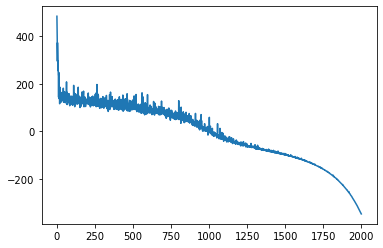

In [48]:
# no minibatching
D = 25
sub_train_features = train_features[:D,:]
sub_train_labels = train_labels[:D]


epochs = 2000
num_samples = 25

variational_network = Variational_Network(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
optimizer = optim.Adam(variational_network.parameters(), lr=0.001)

loss_list = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    loss = -variational_network.evaluate_ELBO(sub_train_features, sub_train_labels)
    loss.backward()
    optimizer.step()
    
    loss_list.append(float(loss.detach().numpy()))
    
plt.plot(loss_list)
plt.show()

# Mini batching

In [47]:
# mini batching
batch_size = 50
epochs = 50
num_samples = 25
variational_network = Variational_Network(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
optimizer = optim.Adam(variational_network.parameters(), lr=0.001)
data_size = train_features.size()[0]
correction_factor = data_size / batch_size

## Train mini w/ batching

In [50]:

loss_list = []
for epoch in range(epochs):
    permutation = torch.randperm(data_size)
    start = time.time()
    
    for i in range(0, data_size, batch_size):
        optimizer.zero_grad()
        idxs = permutation[i: i+batch_size]
        sub_train_features = train_features[idxs]
        sub_train_labels = train_labels[idxs]
        
        loss = -variational_network.evaluate_ELBO(sub_train_features, sub_train_labels, correction=1)
        loss.backward()
        optimizer.step()
        
    loss_list.append(float(loss.detach().numpy()))   
    end = time.time() 
    if epoch % 5 == 0:
        print(f"epoch {epoch} took {str(end - start)[:3]} seconds:", float(loss.detach().numpy()))
        
plt.plot(loss_list)
plt.show()

epoch 0 took 72. seconds: -868802.3125


KeyboardInterrupt: 

In [ ]:


test_N = 100
val_N = 60000 - test_N
test_set, val_set = torch.utils.data.random_split(testset, [test_N, val_N])


# Prepare test set
test_features = torch.cat([data[0].view((1,28*28)) for data in test_set])
test_labels = torch.Tensor([data[1] for data in test_set]).type(torch.long)

preds = variational_network.compute_marginalized_predictions(test_features, num_samples=100)

print("accuracy:", np.sum(np.array(torch.argmax(preds,1) == test_labels))/test_labels.shape[0])

accuracy: 0.49
